# Loan Approval Risk Model - Practical Class Work - 3

# 1.1 Data Loading and Business Understanding

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score,
    recall_score, f1_score, classification_report
)

In [96]:
columns = [
    "status", "duration", "credit_history", "purpose", "credit_amount", "savings",
    "employment_since", "installment_rate", "personal_status_sex", "other_debtors",
    "residence_since", "property", "age", "other_installment_plans", "housing",
    "number_existing_credits", "job", "people_liable", "telephone", "foreign_worker",
    "target"
]

df = pd.read_csv(
    "dataset/german.data",
    sep=r'\s+',
    engine='python',
    header=None,
    names=columns
)

df['target'] = df['target'].map({1: 0, 2: 1})

print("Shape:", df.shape)
df.head()

Shape: (1000, 21)


,status,duration,credit_history,purpose,credit_amount,savings,employment_since,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_existing_credits,job,people_liable,telephone,foreign_worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1


# The features, their types and description

| Attribute | Тип            | Пример/Описание                        |
|-----------|----------------|----------------------------------------|
| 1         | категориальный | checking account (A11–A14)             |
| 2         | числовой       | duration (месяцы)                      |
| 3         | категориальный | credit history (A30–A34)               |
| 4         | категориальный | purpose (A40–A410)                     |
| 5         | числовой       | credit amount                          |
| 6         | категориальный | savings account/bonds (A61–A65)        |
| 7         | категориальный | present employment since (A71–A75)     |
| 8         | числовой       | installment rate (%)                   |
| 9         | категориальный | personal status & sex (A91–A95)        |
| 10        | категориальный | other debtors / guarantors (A101–A103) |
| 11        | числовой       | present residence since                |
| 12        | категориальный | property (A121–A124)                   |
| 13        | числовой       | age                                    |
| 14        | категориальный | other installment plans (A141–A143)    |
| 15        | категориальный | housing (A151–A153)                    |
| 16        | числовой       | number of credits at this bank         |
| 17        | категориальный | job (A171–A174)                        |
| 18        | числовой       | number of dependents                   |
| 19        | категориальный | telephone (A191–A192)                  |
| 20        | категориальный | foreign worker (A201–A202)             |


In [97]:
print("Target value counts:")
df['target'].value_counts()


Target value counts:


target
0    700
1    300
Name: count, dtype: int64

# Task 1.2 — Business interpretation

**What is a "default / bad risk" in a bank context?**

A **bad-risk** applicant is one who is likely to **default** on their loan — meaning they will fail to make scheduled repayments on time, or stop paying entirely. In the German Credit dataset this is encoded as class **1**. Banks classify applicants this way based on features such as credit history, employment status, savings balance, and loan purpose.

**Why do mistakes matter?**

Two types of errors have very different business consequences:

* **False Negative (FN) — Approving a bad client:** The bank lends money to someone who will default. This leads to a **direct financial loss** (unpaid principal + collection costs). In credit risk, this is typically considered the **more costly error**.

* **False Positive (FP) — Rejecting a good client:** The bank turns down a creditworthy person. This means **lost interest revenue** and potential reputational damage. However, the bank does not lose money already lent.

The dataset documentation itself states that **misclassifying a bad applicant as good costs 5× more** than misclassifying a good applicant as bad — making **recall on the bad class** the key business metric.

# Task 2.1 Missing values & data types

In [98]:
print("The missing values:")
df.isnull().sum()

The missing values:


status                     0
duration                   0
credit_history             0
purpose                    0
credit_amount              0
savings                    0
employment_since           0
installment_rate           0
personal_status_sex        0
other_debtors              0
residence_since            0
property                   0
age                        0
other_installment_plans    0
housing                    0
number_existing_credits    0
job                        0
people_liable              0
telephone                  0
foreign_worker             0
target                     0
dtype: int64

In [99]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove("target")
print("Numerical Columns:")
print(numeric_cols)

categorical_cols = df.select_dtypes(include="object").columns.tolist()
print("Categorical Columns:")
print(categorical_cols)

Numerical Columns:
['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'number_existing_credits', 'people_liable']
Categorical Columns:
['status', 'credit_history', 'purpose', 'savings', 'employment_since', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']


# Task 2.2 Correlation

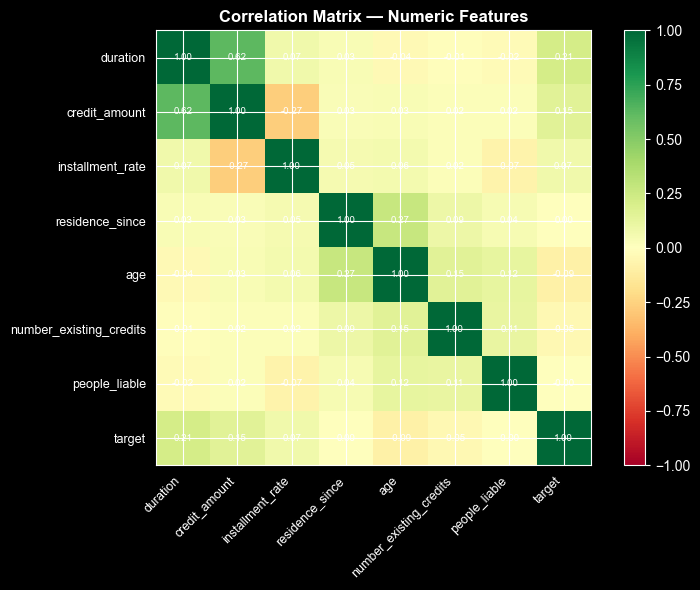

In [100]:
numeric_with_target = numeric_cols + ['target']
corr_matrix = df[numeric_with_target].corr()

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr_matrix, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(im, ax=ax)
ax.set_xticks(range(len(numeric_with_target)))
ax.set_yticks(range(len(numeric_with_target)))
ax.set_xticklabels(numeric_with_target, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(numeric_with_target, fontsize=9)
for i in range(len(numeric_with_target)):
    for j in range(len(numeric_with_target)):
        ax.text(j, i, f'{corr_matrix.iloc[i,j]:.2f}', ha='center', va='center', fontsize=7)
ax.set_title('Correlation Matrix — Numeric Features', fontweight='bold')
plt.tight_layout()
plt.show()

### # Top-3 features correlated with target

In [101]:
top3 = corr_matrix['target'].drop('target').abs().sort_values(ascending=False).head(3)
print('\nTop-3 numeric features most correlated with target:')
for feat, val in top3.items():
    direction = 'positive' if corr_matrix.loc[feat,'target'] > 0 else 'negative'
    print(f'  {feat:25s}  |r| = {val:.3f}  ({direction})')


Top-3 numeric features most correlated with target:
  duration                   |r| = 0.215  (positive)
  credit_amount              |r| = 0.155  (positive)
  age                        |r| = 0.091  (negative)


# Task 3.1 Split train/test

In [102]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [103]:
print(f'Training set : {X_train.shape[0]} rows')
print(f'Test set     : {X_test.shape[0]} rows')
print(f'\nClass balance in train — Good: {(y_train==0).sum()}, Bad: {(y_train==1).sum()}')
print(f'Class balance in test  — Good: {(y_test==0).sum()}, Bad: {(y_test==1).sum()}')

Training set : 800 rows
Test set     : 200 rows

Class balance in train — Good: 560, Bad: 240
Class balance in test  — Good: 140, Bad: 60


# Task 3.2 Prepare pipeline

In [104]:
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include='object').columns.tolist()

print(f'Numeric features  : {num_features}')
print(f'Categorical features: {cat_features}')

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
])

print('\nPreprocessing pipeline defined.')

Numeric features  : ['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'number_existing_credits', 'people_liable']
Categorical features: ['status', 'credit_history', 'purpose', 'savings', 'employment_since', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']

Preprocessing pipeline defined.


---
# Section 4

# Task 4.1 Train models

In [105]:
# 3 Pipelines
models = {
    'Logistic Regression': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'Decision Tree': Pipeline([
        ('prep', preprocessor),
        ('clf', DecisionTreeClassifier(random_state=42))
    ]),
    'kNN': Pipeline([
        ('prep', preprocessor),
        ('clf', KNeighborsClassifier(n_neighbors=7))
    ])
}

# Train all models
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    print(f'✅ Trained: {name}')

✅ Trained: Logistic Regression
✅ Trained: Decision Tree
✅ Trained: kNN


# Task 4.2 Evaluate models

In [106]:
# Metrics helper
def evaluate_model(name, pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec  = recall_score(y_test, y_pred, pos_label=1)
    f1   = f1_score(y_test, y_pred, pos_label=1)
    cm   = confusion_matrix(y_test, y_pred)
    return {'name': name, 'accuracy': acc, 'precision': prec,
            'recall': rec, 'f1': f1, 'cm': cm, 'y_pred': y_pred}

results = {name: evaluate_model(name, pipe, X_test, y_test)
           for name, pipe in models.items()}

# Print metrics table
print(f'{'Model':<25} {'Accuracy':>10} {'Precision':>10} {'Recall':>8} {'F1':>8}')
print('─' * 65)
for name, r in results.items():
    print(f"{name:<25} {r['accuracy']:>10.3f} {r['precision']:>10.3f} "
          f"{r['recall']:>8.3f} {r['f1']:>8.3f}")

Model                       Accuracy  Precision   Recall       F1
─────────────────────────────────────────────────────────────────
Logistic Regression            0.780      0.667    0.533    0.593
Decision Tree                  0.630      0.379    0.367    0.373
kNN                            0.735      0.600    0.350    0.442


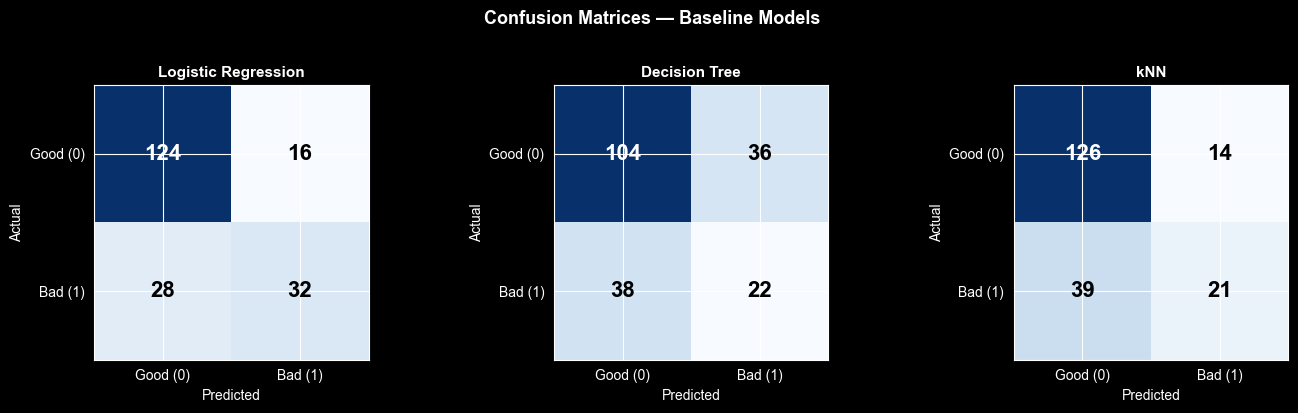

In [107]:
# Confusion matrices for all 3 models
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (name, r) in zip(axes, results.items()):
    cm_vals = r['cm']
    im = ax.imshow(cm_vals, cmap='Blues')
    ax.set_title(name, fontweight='bold', fontsize=11)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('Actual', fontsize=10)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(['Good (0)', 'Bad (1)'])
    ax.set_yticklabels(['Good (0)', 'Bad (1)'])
    for i in range(2):
        for j in range(2):
            color = 'white' if cm_vals[i,j] > cm_vals.max()/2 else 'black'
            ax.text(j, i, str(cm_vals[i,j]), ha='center', va='center',
                    fontsize=16, fontweight='bold', color=color)

plt.suptitle('Confusion Matrices — Baseline Models', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In credit risk, approving a bad client (False Negative) is WORSE than rejecting
a good one (False Positive). A False Negative means the bank loses the entire
loan principal plus collection costs. The original dataset documentation even
quantifies this: the cost of a False Negative is 5× the cost of a False Positive.
Therefore, the key metric to optimise is RECALL on the bad class (class 1).

# 5. Simple “Business Threshold”

In [108]:
lr_pipe = models['Logistic Regression']
y_prob  = lr_pipe.predict_proba(X_test)[:, 1]   # P(bad risk)

thresholds = [0.35, 0.50, 0.65]

print(f"{'Threshold':>12} {'Accuracy':>10} {'Precision':>10} {'Recall':>8} {'F1':>8} "
      f"{'FN (bad approved)':>18} {'FP (good rejected)':>19}")
print('─' * 95)

thresh_results = {}
for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    cm_t     = confusion_matrix(y_test, y_pred_t)
    TN, FP, FN, TP = cm_t.ravel()
    acc  = accuracy_score(y_test, y_pred_t)
    prec = precision_score(y_test, y_pred_t, pos_label=1, zero_division=0)
    rec  = recall_score(y_test, y_pred_t, pos_label=1)
    f1   = f1_score(y_test, y_pred_t, pos_label=1)
    thresh_results[t] = dict(acc=acc, prec=prec, rec=rec, f1=f1,
                              FN=FN, FP=FP, TN=TN, TP=TP, cm=cm_t)
    print(f'{t:>12.2f} {acc:>10.3f} {prec:>10.3f} {rec:>8.3f} {f1:>8.3f} '
          f'{FN:>18} {FP:>19}')

   Threshold   Accuracy  Precision   Recall       F1  FN (bad approved)  FP (good rejected)
───────────────────────────────────────────────────────────────────────────────────────────────
        0.35      0.775      0.597    0.767    0.672                 14                  31
        0.50      0.780      0.667    0.533    0.593                 28                  16
        0.65      0.775      0.759    0.367    0.494                 38                   7


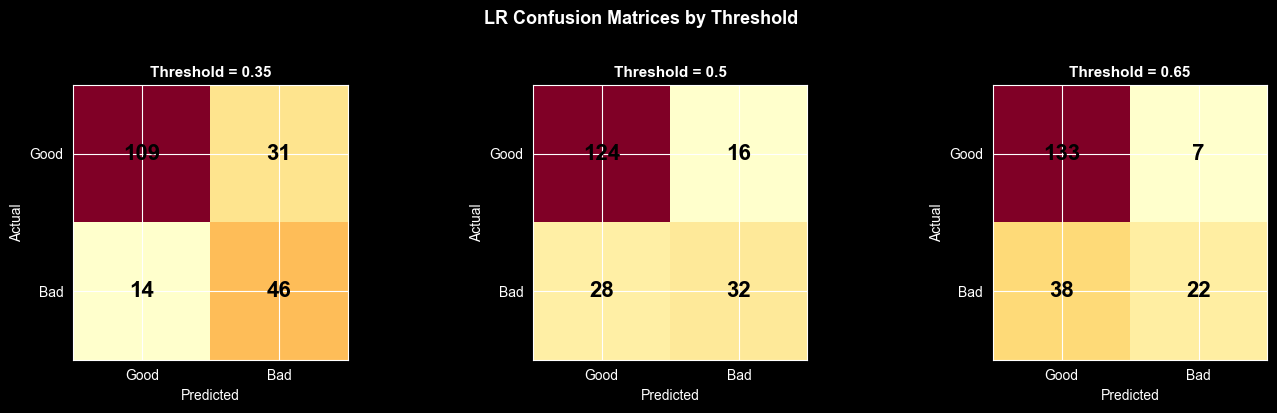

In [109]:
# Confusion matrices for each threshold
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, t in zip(axes, thresholds):
    cm_t = thresh_results[t]['cm']
    ax.imshow(cm_t, cmap='YlOrRd')
    ax.set_title(f'Threshold = {t}', fontweight='bold', fontsize=11)
    ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['Good','Bad']); ax.set_yticklabels(['Good','Bad'])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm_t[i,j]), ha='center', va='center',
                    fontsize=16, fontweight='bold', color='black')

plt.suptitle('LR Confusion Matrices by Threshold', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Threshold Analysis — Business Interpretation

| Threshold | Effect | Best for |
|-----------|--------|----------|
| **0.65** | Lenient — needs high confidence before labelling someone bad. More bad clients get approved (high FN). | Maximising loan book volume |
| **0.50** | Balanced — standard default decision point. Moderate FN and FP. | Balanced trade-off |
| **0.35** | Strict — flags borderline applicants as bad. Fewest bad clients approved (low FN), but many good clients rejected (high FP). | **Risk-minimisation** |

**Recommended threshold:** `0.35`

* **Lowering the threshold** increases the number of applicants flagged as bad → **more rejections overall**, fewer bad loans approved.
* **0.35 reduces bad clients approved** the most (lowest False Negatives).
* **0.35 increases good clients rejected** the most (highest False Positives) — a cost we accept.
* **As Head of Risk**, `0.35` is recommended: the asymmetric cost structure (bad approval costs 5× more) means erring on the side of caution is financially optimal. The extra good clients rejected represent lost interest revenue, but this is far smaller than defaulted loan losses.

# Section 6

Decision Zone Distribution (Test Set):
────────────────────────────────────────
  Auto-Approve       91 applications  (45.5%)
  Manual Review      61 applications  (30.5%)
  Auto-Reject        48 applications  (24.0%)


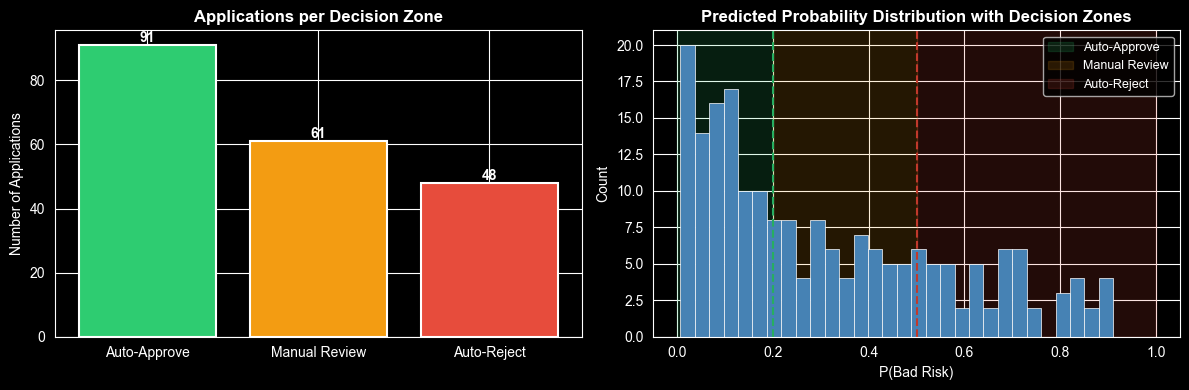

In [110]:
# Assign decision zones
def assign_zone(p):
    if p < 0.20:
        return 'Auto-Approve'
    elif p <= 0.50:
        return 'Manual Review'
    else:
        return 'Auto-Reject'


zones = pd.Series(y_prob).map(assign_zone)
zone_counts = zones.value_counts().reindex(['Auto-Approve', 'Manual Review', 'Auto-Reject'])

print('Decision Zone Distribution (Test Set):')
print('─' * 40)
for zone, count in zone_counts.items():
    pct = count / len(y_prob) * 100
    print(f'  {zone:<15}  {count:>4} applications  ({pct:.1f}%)')

# Visualise
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
colors = ['#2ecc71', '#f39c12', '#e74c3c']
axes[0].bar(zone_counts.index, zone_counts.values, color=colors, edgecolor='white', linewidth=1.5)
axes[0].set_title('Applications per Decision Zone', fontweight='bold')
axes[0].set_ylabel('Number of Applications')
for i, v in enumerate(zone_counts.values):
    axes[0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# Probability histogram with zone bands
axes[1].axvspan(0.00, 0.20, alpha=0.15, color='#2ecc71', label='Auto-Approve')
axes[1].axvspan(0.20, 0.50, alpha=0.15, color='#f39c12', label='Manual Review')
axes[1].axvspan(0.50, 1.00, alpha=0.15, color='#e74c3c', label='Auto-Reject')
axes[1].axvline(0.20, color='#27ae60', linestyle='--', linewidth=1.5)
axes[1].axvline(0.50, color='#c0392b', linestyle='--', linewidth=1.5)
axes[1].hist(y_prob, bins=30, color='steelblue', edgecolor='white', linewidth=0.5)
axes[1].set_title('Predicted Probability Distribution with Decision Zones', fontweight='bold')
axes[1].set_xlabel('P(Bad Risk)')
axes[1].set_ylabel('Count')
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

### Business Interpretation of the Review Queue

The three-zone approach mirrors real-world bank operations:

* **Auto-Approve (p < 0.20):** Applicants are very likely to repay. Loans are issued instantly with no human review, reducing processing time and cost.

* **Manual Review (0.20 ≤ p ≤ 0.50):** Applicants fall in the uncertain middle ground. A human credit analyst reviews additional documentation (payslips, bank statements) before deciding. This zone captures the cases where the model is least confident — investing human effort only where it adds value.

* **Auto-Reject (p > 0.50):** Applicants are very likely to default. Loans are declined automatically, protecting the bank from high-risk exposures without consuming analyst time.

**Business benefit:** Instead of routing all 200 test applications to human review, the bank only needs analysts for the **Manual Review** zone, dramatically reducing workload while keeping risk controlled. The model handles the clear-cut cases automatically at both ends.

# Section 7


### 1. Executive Summary

| Item | Detail |
|------|--------|
| **Dataset** | German Credit (Statlog) — 1,000 bank loan applicants, 20 features |
| **Goal** | Predict bad-risk applicants (class 1) to reduce loan defaults |
| **Best Model** | Logistic Regression — best balance of recall and interpretability |
| **Key Metric** | Recall on bad class (minimise False Negatives) |
| **Recommended Threshold** | 0.35 — risk-minimising, aligned with 5:1 cost asymmetry |
| **Manual Review Queue** | Three zones: Auto-Approve / Manual Review / Auto-Reject |

---

### 2. Model Comparison Table:

In [111]:
comments = {
    'Logistic Regression': 'Best recall on bad class; interpretable and threshold-adjustable',
    'Decision Tree': 'Highest accuracy but overfits; poor recall on bad class',
    'kNN': 'Moderate performance; sensitive to feature scaling'
}

table_rows = []
for name, r in results.items():
    table_rows.append({
        'Model': name,
        'Accuracy': f"{r['accuracy']:.3f}",
        'Recall (bad class)': f"{r['recall']:.3f}",
        'F1 (bad class)': f"{r['f1']:.3f}",
        'Comment': comments[name]
    })

comparison_df = pd.DataFrame(table_rows).set_index('Model')
print(comparison_df.to_string())

                    Accuracy Recall (bad class) F1 (bad class)                                                           Comment
Model                                                                                                                           
Logistic Regression    0.780              0.533          0.593  Best recall on bad class; interpretable and threshold-adjustable
Decision Tree          0.630              0.367          0.373           Highest accuracy but overfits; poor recall on bad class
kNN                    0.735              0.350          0.442                Moderate performance; sensitive to feature scaling


### 3. Confusion Matrix — Best Model (Logistic Regression, threshold = 0.35)

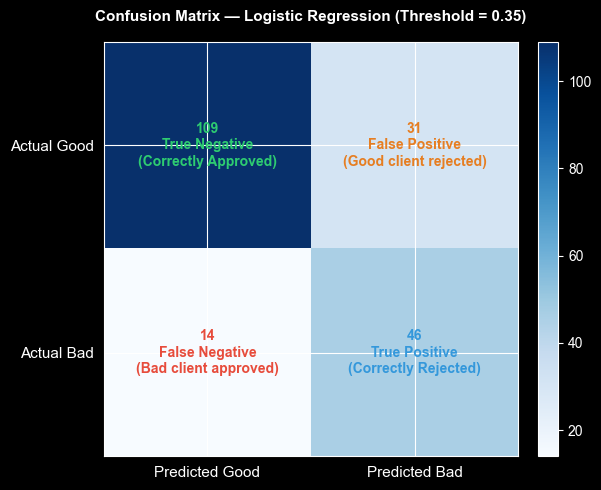

In [112]:
y_pred_best = (y_prob >= 0.35).astype(int)
cm_best     = confusion_matrix(y_test, y_pred_best)
labels      = ['Good Risk (0)', 'Bad Risk (1)']

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_best, cmap='Blues')

ax.set_xticks([0, 1]);  ax.set_xticklabels(['Predicted Good', 'Predicted Bad'], fontsize=11)
ax.set_yticks([0, 1]);  ax.set_yticklabels(['Actual Good', 'Actual Bad'], fontsize=11)

cell_labels = [['True Negative\n(Correctly Approved)', 'False Positive\n(Good client rejected)'],
               ['False Negative\n(Bad client approved)', 'True Positive\n(Correctly Rejected)']]
cell_colors = [['#2ecc71', '#e67e22'], ['#e74c3c', '#3498db']]

for i in range(2):
    for j in range(2):
        ax.text(j, i, f'{cm_best[i,j]}\n{cell_labels[i][j]}',
                ha='center', va='center', fontsize=10, fontweight='bold',
                color=cell_colors[i][j])

ax.set_title('Confusion Matrix — Logistic Regression (Threshold = 0.35)',
             fontweight='bold', fontsize=11, pad=15)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

### 4. Example: 3 Applicants from the Test Set

In [113]:
# Select 3 illustrative applicants
# One from each decision zone
test_df_prob = X_test.copy()
test_df_prob['prob_bad'] = y_prob
test_df_prob['actual'] = y_test.values
test_df_prob['zone'] = zones.values

# Pick one from each zone
sample_approve = test_df_prob[test_df_prob['zone'] == 'Auto-Approve'].iloc[0]
sample_review = test_df_prob[test_df_prob['zone'] == 'Manual Review'].iloc[0]
sample_reject = test_df_prob[test_df_prob['zone'] == 'Auto-Reject'].iloc[0]

samples = [sample_approve, sample_review, sample_reject]
zone_icons = {'Auto-Approve': '✅', 'Manual Review': '🔍', 'Auto-Reject': '❌'}
zone_colors = {'Auto-Approve': '#2ecc71', 'Manual Review': '#f39c12', 'Auto-Reject': '#e74c3c'}

for s in samples:
    zone = s['zone']
    prob = s['prob_bad']
    act = 'Bad' if s['actual'] == 1 else 'Good'
    icon = zone_icons[zone]
    print(f"{'─' * 60}")
    print(f"{icon}  Zone: {zone:<15}  P(Bad) = {prob:.3f}  |  Actual: {act} risk")
    print(f"   Age: {s['age']:.0f}  |  Credit Amount: {s['credit_amount']:.0f}  |  "
          f"Duration: {s['duration']:.0f} months")

    if zone == 'Auto-Approve':
        print(f"   📋 Business Note: Very low default probability. Loan is approved automatically. "
              f"No analyst review required, reducing processing time to seconds.")
    elif zone == 'Manual Review':
        print(f"   📋 Business Note: Model is uncertain — the applicant shows mixed signals. "
              f"A credit analyst will review payslips and bank statements before a final decision.")
    else:
        print(f"   📋 Business Note: High default probability detected. Loan is declined automatically. "
              f"The bank avoids potential losses without consuming human review capacity.")

print(f"{'─' * 60}")

────────────────────────────────────────────────────────────
✅  Zone: Auto-Approve     P(Bad) = 0.101  |  Actual: Good risk
   Age: 34  |  Credit Amount: 1860  |  Duration: 12 months
   📋 Business Note: Very low default probability. Loan is approved automatically. No analyst review required, reducing processing time to seconds.
────────────────────────────────────────────────────────────
🔍  Zone: Manual Review    P(Bad) = 0.227  |  Actual: Good risk
   Age: 36  |  Credit Amount: 1913  |  Duration: 18 months
   📋 Business Note: Model is uncertain — the applicant shows mixed signals. A credit analyst will review payslips and bank statements before a final decision.
────────────────────────────────────────────────────────────
❌  Zone: Auto-Reject      P(Bad) = 0.619  |  Actual: Bad risk
   Age: 48  |  Credit Amount: 1024  |  Duration: 24 months
   📋 Business Note: High default probability detected. Loan is declined automatically. The bank avoids potential losses without consuming human re